perform subsystem and gene-level correlation with pseudotime and secreted IgG as well as Differential Expression Analysis with more focus on secretory machinery

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sns
from matplotlib.pyplot import rc_context
import matplotlib.patches as mpatches
import pickle
from scipy import stats

In [2]:
# read in data

## single-cell subsystem scoring
s_data = pd.read_pickle('../data/dominance_analysis/rna_pseudotime_ppiscore_relimp-input.pkl')


## single-cell secRecon gene expression
g_data = pd.read_pickle('../data/sc_secRecon_expr.pkl')

In [3]:
# import secRecon term2gene dictionary
with open('../data/t2g_dict.pickle', 'rb') as f:
    t2g_dict = pickle.load(f)

# leiden cluster based correlations

In [33]:
# [i for i in g_data.columns if 'IGH' in i]
rna = sc.read('../data/preprocessed_data/rna_pseudotime.h5')
# rna = sc.read('../data/preprocessed_data/rna_pseudotime_ppiscore.h5')
rnaG=rna[rna.obs.Ig=='G']
rnaG=rnaG[rnaG.obs['leiden'].isin(['0','1','2','4','10'])]
rnaG

View of AnnData object with n_obs × n_vars = 8039 × 36691
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'leiden', 'Ig', 'IgL', 'IgH', 'sec', 'dpt_pseudotime', 'distance', 'time3'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
    uns: 'IgL_colors', 'Ig_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'sample_colors', 'sec_colors', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
[i for i in rnaG.var.index if 'IGHG' in i]

['IGHG4', 'IGHG2', 'IGHGP', 'IGHG1', 'IGHG3']

In [34]:
ighg = ['IGHG1','IGHG2','IGHG3','IGHG4']

# get rna_prod.X df for secrecon genes
# rnaG_igg = sc.get.obs_df(rnaG, keys=ighg) # cells x gene
# rnaG_igg

for g in ighg:
    rnaG.obs[g] = rnaG[:,g].X.A.flatten()
    
rnaG.obs['IgG_ADT'] = rnaG.raw.obs_vector('IgG_ADT').tolist()
rnaG.obs

/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_12710/3684962704.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rnaG.obs[g] = rnaG[:,g].X.A.flatten()


,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH,sec,dpt_pseudotime,distance,time3,IGHG1,IGHG2,IGHG3,IGHG4,IgG_ADT
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1,x,0.884599,0.884599,t0,5.348227,1.618039,3.849962,1.512441,4.770685
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1,hi,0.906659,0.906659,t1,5.228555,0.742426,3.878346,1.163793,5.710427
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1,hi,0.892763,0.892763,t0,5.619978,2.174537,3.945220,0.832772,5.252274
AAACGAACAACGTATC-1-0,2231,2231,15467.0,288.0,1.862029,0,1,G,kappa,G1,lo,0.921882,0.921882,t1,5.771496,2.157859,4.285738,1.127223,4.110874
AAACGAACAGACGCTC-1-0,2219,2219,12553.0,514.0,4.094639,0,1,G,kappa,G2,lo,0.910782,0.910782,t1,2.261502,3.350325,1.275153,0.620442,4.465908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCATGTCTGCGGCA-1-2,1988,1988,16355.0,498.0,3.044940,2,0,G,lambda,G1,hi,0.952637,0.952637,t3,4.993800,0.000000,4.128711,3.334966,6.822197
TTTCCTCCACACCTTC-1-2,2014,2014,14104.0,230.0,1.630743,2,0,G,lambda,G1,lo,0.936860,0.936860,t2,4.408036,1.573987,3.002174,0.928354,4.574711
TTTCCTCGTCTGTGGC-1-2,1509,1509,14251.0,235.0,1.649007,2,0,G,lambda,G1,hi,0.961848,0.961848,t3,5.170300,1.855591,3.484376,0.932780,5.846439
TTTCGATGTAACATCC-1-2,1846,1846,11623.0,160.0,1.376581,2,4,G,lambda,G1,x,0.958985,0.958985,t3,6.212631,2.138760,4.679507,0.660683,5.159055


In [35]:
# for each leiden cluster, perform IGHG correlation with sec Ig and pseudotime
## does cluster 10 have a different correlation profile than other clusters?
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# Columns to correlate
feature_cols = ighg
response_cols = ['IgG_ADT', 'dpt_pseudotime']

# Store results
results = []

# Group by 'cluster' and compute correlations
for cluster, group in rnaG.obs.groupby('leiden'):
    for feature in feature_cols:
        for response in response_cols:
            corr, pval = stats.spearmanr(group[feature], group[response])
            results.append([cluster, feature, response, corr, pval])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['leiden', 'feature', 'response', 'spearman_corr', 'p_value'])

# Correct p-values using Benjamini-Hochberg
results_df['p_adjusted'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Display the results
# print(results_df)
results_df

,leiden,feature,response,spearman_corr,p_value,p_adjusted
0,0,IGHG1,IgG_ADT,0.202543,1.036565e-23,1.036565e-22
1,0,IGHG1,dpt_pseudotime,0.039868,5.045073e-02,7.761651e-02
2,0,IGHG2,IgG_ADT,-0.046592,2.223253e-02,3.557205e-02
3,0,IGHG2,dpt_pseudotime,-0.094918,3.072851e-06,7.230237e-06
4,0,IGHG3,IgG_ADT,0.133565,4.695088e-11,1.878035e-10
5,0,IGHG3,dpt_pseudotime,0.123698,1.127113e-09,4.098592e-09
6,0,IGHG4,IgG_ADT,0.282053,2.811521e-45,5.623043e-44
7,0,IGHG4,dpt_pseudotime,0.105885,1.910437e-07,5.878268e-07
8,1,IGHG1,IgG_ADT,0.224060,3.053867e-26,4.071822e-25
9,1,IGHG1,dpt_pseudotime,0.088175,3.700352e-05,8.223005e-05


In [54]:
# save correlations as csv
results_df.to_csv('../results/correlation/igg_leiden_igg-subtype_response_corr_unpivot.csv')

results_df.pivot(index=['leiden', 'response'], columns='feature', values='spearman_corr').to_csv('../results/correlation/igg_leiden_igg-subtype_response_corr.csv')

results_df.pivot(index=['leiden', 'response'], columns='feature', values='spearman_corr')


feature                   IGHG1     IGHG2     IGHG3     IGHG4
leiden response                                              
0      IgG_ADT         0.202543 -0.046592  0.133565  0.282053
       dpt_pseudotime  0.039868 -0.094918  0.123698  0.105885
1      IgG_ADT         0.224060  0.081950  0.197943  0.208991
       dpt_pseudotime  0.088175 -0.052059  0.110816 -0.022336
10     IgG_ADT        -0.000162 -0.088087  0.000560  0.182047
       dpt_pseudotime  0.067648 -0.058152 -0.001468  0.092797
2      IgG_ADT         0.159559 -0.117895  0.164261  0.339477
       dpt_pseudotime  0.040997 -0.038287  0.052423 -0.056273
4      IgG_ADT         0.159022  0.026679  0.105194  0.292808
       dpt_pseudotime  0.057691 -0.003111  0.156013 -0.006192

In [40]:
results_df[results_df['response'] == 'IgG_ADT'].pivot(index=['leiden', 'response'], columns='feature', values='spearman_corr')


,feature,IGHG1,IGHG2,IGHG3,IGHG4
leiden,response,,,,
0,IgG_ADT,0.202543,-0.046592,0.133565,0.282053
1,IgG_ADT,0.224060,0.081950,0.197943,0.208991
10,IgG_ADT,-0.000162,-0.088087,0.000560,0.182047
2,IgG_ADT,0.159559,-0.117895,0.164261,0.339477
4,IgG_ADT,0.159022,0.026679,0.105194,0.292808


In [39]:
results_df[results_df['response'] == 'dpt_pseudotime'].pivot(index=['leiden', 'response'], columns='feature', values='spearman_corr')


,feature,IGHG1,IGHG2,IGHG3,IGHG4
leiden,response,,,,
0,dpt_pseudotime,0.039868,-0.094918,0.123698,0.105885
1,dpt_pseudotime,0.088175,-0.052059,0.110816,-0.022336
10,dpt_pseudotime,0.067648,-0.058152,-0.001468,0.092797
2,dpt_pseudotime,0.040997,-0.038287,0.052423,-0.056273
4,dpt_pseudotime,0.057691,-0.003111,0.156013,-0.006192


<Axes: xlabel='leiden', ylabel='dpt_pseudotime'>

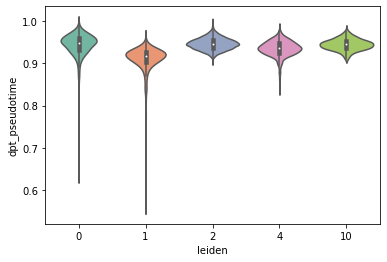

In [41]:
sns.violinplot(x='leiden', y='dpt_pseudotime', data=rnaG.obs, inner="box", palette="Set2")


In [43]:
set(rnaG.obs['time3'])

{'0', 't0', 't1', 't2', 't3', 't4'}

leiden,0,1,2,4,10
time3,,,,,
0,0.014535,0.055428,0.000000,0.001079,0.000000
t0,0.035714,0.147962,0.000000,0.032362,0.000000
t1,0.115864,0.489693,0.047880,0.207120,0.067073
t2,0.349252,0.303252,0.554036,0.553398,0.585366
t3,0.425249,0.003665,0.374373,0.199569,0.338415
t4,0.059385,0.000000,0.023712,0.006472,0.009146


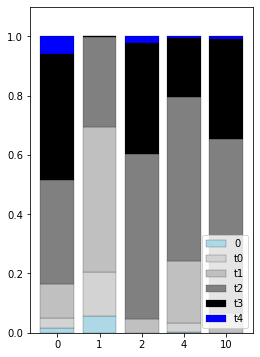

In [51]:
d=rnaG.obs[rnaG.obs['leiden'].isin(['0','1','2','4','10'])]
dd=rnaG.obs.groupby('leiden')['time3'].value_counts(normalize=True).unstack('leiden')
dd = dd[['0','1','2','4','10']]

al=d['time3'].value_counts(normalize=True)

# dd['G']= al
labels = dd.columns
# dd=dd.drop["x"]
tmp1 = dd.iloc[0]
tmp2 =  dd.iloc[1]
tmp3 = dd.iloc[2]
tmp4 = dd.iloc[3]
tmp5 = dd.iloc[4]
tmp6 = dd.iloc[5]


fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
width = 0.8       # the width of the bars: can also be len(x) sequence

ax.bar(labels, tmp1, width, label='0',color='lightblue',linewidth=0.2,edgecolor='k')
ax.bar(labels, tmp2, width,  label='t0',bottom=tmp1,color='lightgrey',linewidth=0.2,edgecolor='k',
)
ax.bar(labels, tmp3, width,  label='t1',bottom=tmp1+tmp2,color='silver',linewidth=0.2,edgecolor='k',
)
ax.bar(labels, tmp4, width,  label='t2',bottom=tmp1+tmp2+tmp3,color='grey',linewidth=0.2,edgecolor='k',
)
ax.bar(labels, tmp5, width,  label='t3',bottom=tmp1+tmp2+tmp3+tmp4,color='black',linewidth=0.2,edgecolor='k',
)
ax.bar(labels, tmp6, width,  label='t4',bottom=tmp1+tmp2+tmp3+tmp4+tmp5,color='blue',linewidth=0.2,edgecolor='k',
)
# ax.bar(labels, tmp4, width,  label='t2',bottom=tmp1+tmp2+tmp3,color='darkorange',linewidth=0.2,edgecolor='k',
# )

plt.ylim(0,1.1)

plt.legend(loc='lower right')
# plt.show()

plt.savefig('../results/umap/leiden_pseudotime_group_barplot.pdf')

dd

# perform subsystem-level correlation

across all cells

In [213]:
# phenotype responses
cols_response = ['dpt_pseudotime','IgG_ADT']

# columns of grouping/features
cols_meta = ['leiden','Ig','IgL','IgH','sec','sample']

cols_scores = [i for i in s_data.columns if 'score' in i]
cols_ppi = [i for i in s_data.columns if 'ppi' in i]
cols_gobp = [i for i in s_data.columns if 'GOBP' in i]
cols_transcription = ['hc_avgexpr']

cols_allfeatures = cols_scores + cols_ppi + cols_gobp + cols_transcription
len(cols_allfeatures) # how many features

136

In [ ]:
## single-cell correlation of subsystem expr scoring, PPI activity to responses (pseudotime, IgG)

In [217]:
subsys_corr = {}
for p in cols_response:
    if p == 'dpt_pseudotime':
        feat = cols_allfeatures+['IgG_ADT']
    else:
        feat = cols_allfeatures+['dpt_pseudotime']
    p_corr = pd.DataFrame(index=[i for i in feat],
                          columns=['SCC','pval'])

    for i in feat:
        i_corr = stats.spearmanr(s_data[i],s_data[p])
        p_corr.loc[i,'SCC']= i_corr[0]
        p_corr.loc[i,'pval']= i_corr[1]
        
        
    # remove nan rows
    p_corr = p_corr.dropna(axis=0)
    # correct p-value
    p_corr['bh_pval'] = stats.false_discovery_control(pd.to_numeric(p_corr['pval']),method='bh')
        
    subsys_corr[p] = p_corr
#     p_corr = pd.DataFrame(index=[i for i in [*t2g_dict]+cols_gobp + cols_transcription],
#                           columns=['score_PCC','ppi_PCC','score_pval','ppi_pval'])

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [86]:
# top pathways correlating with pseudotime
subsys_corr[cols_response[0]].sort_values('SCC').head(15), subsys_corr[cols_response[0]].sort_values('SCC',ascending=False).head(15)

(                                           SCC pval  bh_pval
 Cytoskeletal remodeling_ppi          -0.608072  0.0      0.0
 Vesicle trafficking_ppi              -0.601374  0.0      0.0
 Post-Golgi_ppi                       -0.599154  0.0      0.0
 Ubiquitination_ppi                   -0.592648  0.0      0.0
 Endocytosis_ppi                      -0.562405  0.0      0.0
 Proteostasis_ppi                     -0.556586  0.0      0.0
 GOBP_CYTOPLASMIC_TRANSLATION         -0.545618  0.0      0.0
 ERAD_ppi                             -0.538363  0.0      0.0
 Proteasomal degradation_ppi           -0.52859  0.0      0.0
 Autophagy (Vesicle trafficking)_ppi  -0.518346  0.0      0.0
 Cytoskeletal remodeling_score        -0.495426  0.0      0.0
 ER stress response/UPR_ppi           -0.464338  0.0      0.0
 Mislocalized protein degradation_ppi -0.463466  0.0      0.0
 IRE1 pathway_ppi                     -0.459855  0.0      0.0
 PERK pathway_ppi                     -0.452139  0.0      0.0,
       

In [215]:
# subset for IgG (G) population
## subprocess scoring correlation to IgG and pseudotime
s_data_g = s_data[s_data['Ig'] == 'G']

subsys_corr_g = {}
for p in cols_response:
    if p == 'dpt_pseudotime':
        feat = cols_allfeatures+['IgG_ADT']
    else:
        feat = cols_allfeatures+['dpt_pseudotime']
    p_corr = pd.DataFrame(index=[i for i in feat],
                          columns=['SCC','pval'])

    for i in feat:
        i_corr = stats.spearmanr(s_data_g[i],s_data_g[p])
        p_corr.loc[i,'SCC']= i_corr[0]
        p_corr.loc[i,'pval']= i_corr[1]
        
        
    # remove nan rows
    p_corr = p_corr.dropna(axis=0)
    # correct p-value
    p_corr['bh_pval'] = stats.false_discovery_control(pd.to_numeric(p_corr['pval']),method='bh')
        
    subsys_corr_g[p] = p_corr

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [88]:
# top 15 pathways correlating with secreted IgG for G population
subsys_corr_g[cols_response[1]].sort_values('SCC').head(15), subsys_corr_g[cols_response[1]].sort_values('SCC',ascending=False).head(15), 

(                                             SCC pval        bh_pval
 Hydroxylysine_score                    -0.276614  0.0  1.001131e-141
 Dermatan sulfate_score                 -0.226316  0.0   2.983716e-94
 Heparan sulfate_score                  -0.222337  0.0   5.943194e-91
 SLC acetyl-CoA transporter_score       -0.204407  0.0   7.482414e-77
 Acetylation_score                      -0.200258  0.0   8.495087e-74
 Glycosaminoglycan_score                -0.199505  0.0   2.946893e-73
 Globo series_score                     -0.197574  0.0   7.342707e-72
 Carboxylase_score                      -0.194642  0.0   9.089637e-70
 O-glycan not-mucin_score               -0.166132  0.0   4.781269e-51
 Kinase_score                           -0.161051  0.0   4.712311e-48
 O-glycan mucin_score                   -0.140431  0.0   7.389946e-37
 Carboxylation_score                    -0.139971  0.0   1.250949e-36
 O-glycan_score                         -0.136657  0.0   5.490443e-35
 Chondroitin sulfate

In [89]:
# top 15 pathways correlating with pseudotime for G population
subsys_corr_g[cols_response[0]].sort_values('SCC').head(15), subsys_corr_g[cols_response[0]].sort_values('SCC',ascending=False).head(15), 

(                                    SCC pval  bh_pval
 Proteostasis_ppi              -0.582517  0.0      0.0
 Vesicle trafficking_ppi       -0.572967  0.0      0.0
 Ubiquitination_ppi            -0.571692  0.0      0.0
 ERAD_ppi                      -0.565678  0.0      0.0
 Cytoskeletal remodeling_ppi   -0.552681  0.0      0.0
 Post-Golgi_ppi                -0.552665  0.0      0.0
 ER stress response/UPR_ppi    -0.530086  0.0      0.0
 GOBP_CYTOPLASMIC_TRANSLATION  -0.529599  0.0      0.0
 IRE1 pathway_ppi               -0.52115  0.0      0.0
 Protein conformation_ppi      -0.515827  0.0      0.0
 Endocytosis_ppi               -0.511346  0.0      0.0
 Protein folding_ppi           -0.510002  0.0      0.0
 Proteasomal degradation_ppi   -0.509794  0.0      0.0
 PERK pathway_ppi              -0.465577  0.0      0.0
 Cytoskeletal remodeling_score -0.456006  0.0      0.0,
                                              SCC pval        bh_pval
 Heparan sulfate_score                   0.303254

In [318]:
# add metric type to subsystem corr df
for i in [*subsys_corr]:
    i_met = []
    
    for s in subsys_corr[i].index:
        if 'score' in s:
            i_met.append('score')
        elif 'ppi' in s:
            i_met.append('ppi')
        else:
            i_met.append(np.nan)
            
    subsys_corr[i]['feature'] = i_met
    
for i in [*subsys_corr_g]:
    i_met = []
    
    for s in subsys_corr_g[i].index:
        if 'score' in s:
            i_met.append('score')
        elif 'ppi' in s:
            i_met.append('ppi')
        else:
            i_met.append(np.nan)
            
    subsys_corr_g[i]['feature'] = i_met
    
subsys_corr['dpt_pseudotime']

,SCC,pval,bh_pval,feature
Proteostasis_score,-0.288971,0.0,6.824821e-246,score
Protein conformation_score,-0.264527,0.0,6.373767e-205,score
Glycerophospholipid (GPI anchor)_score,0.055375,0.0,3.418417e-10,score
COPII_score,0.050191,0.0,1.249495e-08,score
Carboxylase_score,0.191661,0.0,1.173915e-106,score
...,...,...,...,...
ATF6 pathway_ppi,-0.127494,0.0,1.027549e-47,ppi
GOBP_CYTOPLASMIC_TRANSLATION,-0.545618,0.0,0.000000e+00,NaN
GOBP_OXIDATIVE_PHOSPHORYLATION,-0.358618,0.0,0.000000e+00,NaN
hc_avgexpr,0.278521,0.0,7.637821e-228,NaN


In [186]:
for i in [*subsys_corr]:
    subsys_corr[i].to_csv('../results/correlation/subsys_corr-'+i+'.csv')

In [240]:
# bar plot for correlations
with open('../data/ont_c2p_2.pickle', 'rb') as f:
    ont_c2p_2 = pickle.load(f)
    
# color key for subsystems
colors_system = {'IgG_transcription': 'lightblue','translation': 'salmon','oxphos': 'firebrick',
        'Proteostasis': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
                'Autophagy (Proteostasis)': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),

                 'ER stress response/UPR': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
        'ERAD': (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
        'ERpQC':  (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
        'Mislocalized protein degradation': (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
        'Apoptosis': (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
        'ER Ca Homeostasis' : (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
        'MAPS': (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
        'Lysosomal degradation/Glyco-conjugate degradation': 'lightcyan',
        'Vesicle trafficking': (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
        'Autophagy (Vesicle trafficking)': (0.5490196078431373, 0.6352941176470588, 0.3215686274509804), 
        'Cytoskeletal remodeling': (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
        'Membrane fusion': (0.807843137254902, 0.8588235294117647, 0.611764705882353),
        'Post-Golgi': (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
        'Pre-Golgi': (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
        'Targeting to correct compartment/cargo sorting': (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
        'Vesicle budding': (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
                         'Golgi organization': (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),

                'Acetylation': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
        'Carboxylation': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
        'Hydroxylysine': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
                'Lipidation': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
        'O-sulfation': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
        'Phosphorylation': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
                 'Post-translational modifications': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),      
        'Glycosylation': (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
        'Disulfide bond formation': (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),     
        'Protein conformation': 'orchid', 'Translocation': 'thistle', 'pseudotime': 'red'
         }

In [317]:
subsys_corr_g['IgG_ADT']

,SCC,pval,bh_pval
Proteostasis_score,0.500203,0.0,0.000000e+00
Protein conformation_score,0.498452,0.0,0.000000e+00
Glycerophospholipid (GPI anchor)_score,0.092626,0.0,7.417361e-17
COPII_score,0.068347,0.0,7.743511e-10
Carboxylase_score,-0.194642,0.0,9.089637e-70
...,...,...,...
ATF6 pathway_ppi,0.121565,0.0,5.500226e-28
GOBP_CYTOPLASMIC_TRANSLATION,0.4449,0.0,0.000000e+00
GOBP_OXIDATIVE_PHOSPHORYLATION,0.567481,0.0,0.000000e+00
hc_avgexpr,0.301603,0.0,1.777287e-169


In [319]:
# add system for visualization
subsys_corr_igg = subsys_corr_g['IgG_ADT'].copy()
subsys_corr_igg = subsys_corr_igg[~pd.isna(subsys_corr_igg['feature'])]
subsys_corr_igg['term'] = subsys_corr_igg.index.tolist()
subsys_corr_igg['system'] = [ont_c2p_2[i.split('_')[0]] for i in subsys_corr_igg.index]
subsys_corr_igg['color'] = [colors_system[i] for i in subsys_corr_igg.system]
subsys_corr_igg

,SCC,pval,bh_pval,feature,term,system,color
Proteostasis_score,0.500203,0.0,0.000000e+00,score,Proteostasis_score,Proteostasis,"(0.2235294117647059, 0.23137254901960785, 0.47..."
Protein conformation_score,0.498452,0.0,0.000000e+00,score,Protein conformation_score,Protein conformation,orchid
Glycerophospholipid (GPI anchor)_score,0.092626,0.0,7.417361e-17,score,Glycerophospholipid (GPI anchor)_score,Glycosylation,"(0.9921568627450981, 0.5529411764705883, 0.235..."
COPII_score,0.068347,0.0,7.743511e-10,score,COPII_score,Pre-Golgi,"(0.6313725490196078, 0.8509803921568627, 0.607..."
Carboxylase_score,-0.194642,0.0,9.089637e-70,score,Carboxylase_score,Carboxylation,"(0.9019607843137255, 0.3333333333333333, 0.050..."
...,...,...,...,...,...,...,...
Cytoskeletal remodeling_ppi,0.230197,0.0,1.595986e-97,ppi,Cytoskeletal remodeling_ppi,Cytoskeletal remodeling,"(0.7098039215686275, 0.8117647058823529, 0.419..."
Golgi organization_ppi,0.125977,0.0,6.096655e-30,ppi,Golgi organization_ppi,Golgi organization,"(0.19215686274509805, 0.6392156862745098, 0.32..."
Glycosphingolipid_ppi,0.163484,0.0,1.798728e-49,ppi,Glycosphingolipid_ppi,Glycosylation,"(0.9921568627450981, 0.5529411764705883, 0.235..."
Glycosylation_ppi,0.206638,0.0,1.581626e-78,ppi,Glycosylation_ppi,Glycosylation,"(0.9921568627450981, 0.5529411764705883, 0.235..."


In [242]:
# add system for visualization
subsys_corr_dpt = subsys_corr['dpt_pseudotime'].copy()
subsys_corr_dpt = subsys_corr_dpt[~pd.isna(subsys_corr_dpt['feature'])]
subsys_corr_dpt['term'] = subsys_corr_dpt.index.tolist()
subsys_corr_dpt['system'] = [ont_c2p_2[i.split('_')[0]] for i in subsys_corr_dpt.index]
subsys_corr_dpt['color'] = [colors_system[i] for i in subsys_corr_dpt.system]
subsys_corr_dpt

,SCC,pval,bh_pval,feature,term,system,color
Proteostasis_score,-0.288971,0.0,6.824821e-246,score,Proteostasis_score,Proteostasis,"(0.2235294117647059, 0.23137254901960785, 0.47..."
Protein conformation_score,-0.264527,0.0,6.373767e-205,score,Protein conformation_score,Protein conformation,orchid
Glycerophospholipid (GPI anchor)_score,0.055375,0.0,3.418417e-10,score,Glycerophospholipid (GPI anchor)_score,Glycosylation,"(0.9921568627450981, 0.5529411764705883, 0.235..."
COPII_score,0.050191,0.0,1.249495e-08,score,COPII_score,Pre-Golgi,"(0.6313725490196078, 0.8509803921568627, 0.607..."
Carboxylase_score,0.191661,0.0,1.173915e-106,score,Carboxylase_score,Carboxylation,"(0.9019607843137255, 0.3333333333333333, 0.050..."
...,...,...,...,...,...,...,...
Cytoskeletal remodeling_ppi,-0.608072,0.0,0.000000e+00,ppi,Cytoskeletal remodeling_ppi,Cytoskeletal remodeling,"(0.7098039215686275, 0.8117647058823529, 0.419..."
Golgi organization_ppi,-0.084079,0.0,1.360094e-21,ppi,Golgi organization_ppi,Golgi organization,"(0.19215686274509805, 0.6392156862745098, 0.32..."
Glycosphingolipid_ppi,-0.372167,0.0,0.000000e+00,ppi,Glycosphingolipid_ppi,Glycosylation,"(0.9921568627450981, 0.5529411764705883, 0.235..."
Glycosylation_ppi,-0.375396,0.0,0.000000e+00,ppi,Glycosylation_ppi,Glycosylation,"(0.9921568627450981, 0.5529411764705883, 0.235..."


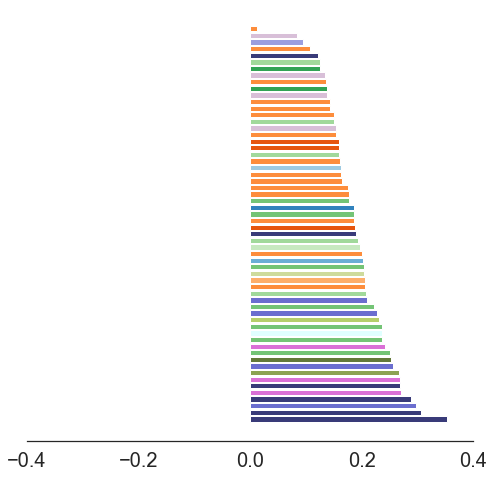

In [328]:
subsys_corr_igg_viz = subsys_corr_igg[subsys_corr_igg['feature']=='ppi'].sort_values('SCC',ascending=False)

sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,8))

# Plot horizontal bars
bars = ax.barh(subsys_corr_igg_viz['term'], subsys_corr_igg_viz['SCC'],color=subsys_corr_igg_viz['color']) #, color=colors

# Hide y-axis labels
ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(-0.4,0.4)

# Show the plot
plt.show()

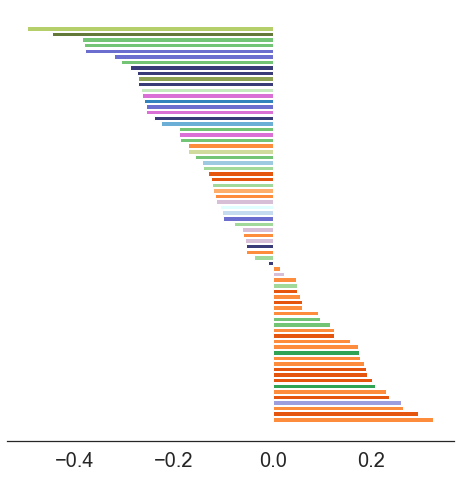

In [304]:
subsys_corr_dpt_viz = subsys_corr_dpt[subsys_corr_dpt['feature']=='score'].sort_values('SCC',ascending=False)
# subsys_corr_dpt_viz = subsys_corr_dpt.sort_values('SCC',ascending=False)

sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,8))

# Plot horizontal bars
bars = ax.barh(subsys_corr_dpt_viz['term'], subsys_corr_dpt_viz['SCC'],color=subsys_corr_dpt_viz['color']) #, color=colors

# Hide y-axis labels
ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()

correlation -  group by leiden cluster

In [77]:
leiden_c = []
[leiden_c.append(str(i)+'_SCC') for i in set(s_data['leiden'])]
[leiden_c.append(str(i)+'_pval') for i in set(s_data['leiden'])]

igg_clusters = [0,1,2,4,10]
leiden_c_igg = []
[leiden_c_igg.append(str(i)+'_SCC') for i in igg_clusters]
[leiden_c_igg.append(str(i)+'_pval') for i in igg_clusters]

[None, None, None, None, None]

In [ ]:
# perform subprocess correlations for each leiden cluster

In [91]:
subsys_corr_leiden = {}
for p in cols_response:
    if p == 'dpt_pseudotime':
        feat = cols_allfeatures+['IgG_ADT']
    else:
        feat = cols_allfeatures+['dpt_pseudotime']
    p_corr = pd.DataFrame(index=[i for i in feat],
                          columns=leiden_c)

    for c in list(set(s_data['leiden'])):
    
        # get cell ids in cluster
        c_cells = s_data[s_data['leiden'] == c].index.tolist()
    
        for i in feat:
            i_corr = stats.spearmanr(s_data.loc[c_cells,i],s_data.loc[c_cells,p])
            p_corr.loc[i,c+'_SCC']= i_corr[0]
            p_corr.loc[i,c+'_pval']= i_corr[1]
        
    # remove nan rows
#     p_corr = p_corr.dropna(axis=0)
    # correct p-value
#     p_corr['bh_pval'] = stats.false_discovery_control(pd.to_numeric(p_corr['pval']),method='bh')
        
    subsys_corr_leiden[p] = p_corr

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

# gene-level correlation

In [261]:
# 83 secRecon genes removed due to zero expression in all cells
## 1017 tot secRecon genes
g_data_flt = g_data.loc[:, (g_data != 0).any(axis=0)].copy()
g_data_flt

,PIGF,TRIM5,ALG8,B4GALT4,CYTH4,DPM2,ALG1L,TBC1D20,TRIM22,PIGA,...,ARHGEF1,SLC35A5,PGRMC1,PPP1R15B,PPIL3,ALG3,GANAB,HSPA12A,DNAJC14,DDOST
AAACCCAAGTACTGTC-1-0,0.409058,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.409058,0.000000,0.409058,0.000000,0.409058,0.409058,0.0,0.000000,0.698532
AAACCCAAGTGAATAC-1-0,0.000000,0.0,0.000000,0.000000,1.029481,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.029481
AAACCCAGTCCACAGC-1-0,0.742426,0.0,0.000000,0.438586,0.000000,0.438586,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.438586,0.000000,0.438586,0.438586,0.0,0.000000,1.163793
AAACCCATCACAGTGT-1-0,0.624812,0.0,0.000000,0.000000,0.624812,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.624812,0.000000
AAACCCATCCCTCTCC-1-0,0.000000,0.0,0.000000,0.000000,0.832772,0.000000,0.0,0.000000,0.0,0.0,...,0.500680,0.000000,0.500680,0.000000,0.000000,0.000000,0.500680,0.0,0.000000,0.500680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,0.545914,0.0,0.000000,0.000000,0.545914,0.545914,0.0,0.545914,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
TTTGTTGAGGTACAAT-1-2,0.000000,0.0,0.569612,0.000000,0.000000,0.569612,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.569612,0.000000,0.569612,0.000000,0.0,0.000000,0.569612
TTTGTTGAGTAACGAT-1-2,0.000000,0.0,0.000000,0.464203,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.464203,0.000000,0.464203,0.780009,0.000000,0.0,0.000000,0.000000
TTTGTTGCACGTTGGC-1-2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.439152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.439152


In [262]:
# gene-level correlation for all cells
gene_corr = {}
for p in cols_response:
    p_corr = pd.DataFrame(index=[i for i in g_data_flt.columns],
                          columns=['SCC','pval'])

    for i in g_data_flt.columns:
        i_corr = stats.spearmanr(g_data_flt[i],s_data[p])
        p_corr.loc[i,'SCC']= i_corr[0]
        p_corr.loc[i,'pval']= i_corr[1]
        
        
    # remove nan rows
    p_corr = p_corr.dropna(axis=0)
    # correct p-value
    p_corr['bh_pval'] = stats.false_discovery_control(pd.to_numeric(p_corr['pval']),method='bh')
        
    gene_corr[p] = p_corr
    
# gene-level correlation for only IgG (G) cells
gene_corr_g = {}

# obtain IgG cell ids
g_data_flt_igg = g_data_flt.loc[s_data_g.index.tolist(),:].copy()


for p in cols_response:
    p_corr = pd.DataFrame(index=[i for i in g_data_flt.columns],
                          columns=['SCC','pval'])

    for i in g_data_flt.columns:
        i_corr = stats.spearmanr(g_data_flt_igg[i],s_data_g[p])
        p_corr.loc[i,'SCC']= i_corr[0]
        p_corr.loc[i,'pval']= i_corr[1]
        
        
    # remove nan rows
    p_corr = p_corr.dropna(axis=0)
    # correct p-value
    p_corr['bh_pval'] = stats.false_discovery_control(pd.to_numeric(p_corr['pval']),method='bh')
        
    gene_corr_g[p] = p_corr

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [ ]:
# VISUALIZE subprocess and gene-level correlations

In [313]:
# add system for visualization

## igg correlation
gene_corr_igg = gene_corr_g['IgG_ADT'].copy()
gene_corr_igg['gene'] = gene_corr_igg.index.tolist()
gene_corr_igg['system'] = [gene_dict[i]['systems'][0] for i in gene_corr_igg['gene']]
gene_corr_igg['color'] = [colors_system[i] for i in gene_corr_igg.system]
gene_corr_igg

,SCC,pval,bh_pval,gene,system,color
PIGF,0.076142,0.0,1.693317e-11,PIGF,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
TRIM5,0.032502,0.003427,4.428603e-03,TRIM5,Proteostasis,"(0.2235294117647059, 0.23137254901960785, 0.47..."
ALG8,0.071779,0.0,2.231511e-10,ALG8,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
B4GALT4,0.061042,0.0,6.917612e-08,B4GALT4,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
CYTH4,0.065225,0.0,8.251673e-09,CYTH4,Vesicle trafficking,"(0.38823529411764707, 0.4745098039215686, 0.22..."
...,...,...,...,...,...,...
ALG3,0.066744,0.0,3.677919e-09,ALG3,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
GANAB,0.060896,0.0,7.413512e-08,GANAB,Protein conformation,orchid
HSPA12A,0.033659,0.002439,3.200562e-03,HSPA12A,Protein conformation,orchid
DNAJC14,0.055207,0.000001,1.095740e-06,DNAJC14,Protein conformation,orchid


In [266]:
# add system for visualization
## pseudotime correlation
gene_corr_dpt = gene_corr['dpt_pseudotime'].copy()
gene_corr_dpt['gene'] = gene_corr_dpt.index.tolist()
gene_corr_dpt['system'] = [gene_dict[i]['systems'][0] for i in gene_corr_dpt['gene']]
gene_corr_dpt['color'] = [colors_system[i] for i in gene_corr_dpt.system]
gene_corr_dpt

,SCC,pval,bh_pval,gene,system,color
PIGF,-0.052909,0.0,2.747738e-09,PIGF,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
TRIM5,-0.072769,0.0,2.411270e-16,TRIM5,Proteostasis,"(0.2235294117647059, 0.23137254901960785, 0.47..."
ALG8,-0.057622,0.0,9.023343e-11,ALG8,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
B4GALT4,-0.082931,0.0,8.348092e-21,B4GALT4,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
CYTH4,-0.037079,0.000025,3.305590e-05,CYTH4,Vesicle trafficking,"(0.38823529411764707, 0.4745098039215686, 0.22..."
...,...,...,...,...,...,...
ALG3,0.038027,0.000016,2.055376e-05,ALG3,Post-translational modifications,"(0.9019607843137255, 0.3333333333333333, 0.050..."
GANAB,-0.090546,0.0,1.604166e-24,GANAB,Protein conformation,orchid
HSPA12A,-0.021562,0.014356,1.701659e-02,HSPA12A,Protein conformation,orchid
DNAJC14,-0.084121,0.0,2.304400e-21,DNAJC14,Protein conformation,orchid


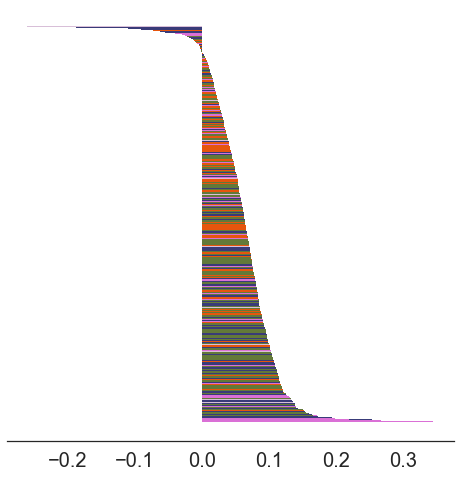

In [314]:
#  viz secRecon gene expression correlation with igg secretion
gene_corr_igg_viz = gene_corr_igg[gene_corr_igg['SCC'].abs() > 0.0].sort_values('SCC',ascending=False)

sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,8))

# Plot horizontal bars
bars = ax.barh(gene_corr_igg_viz['gene'], gene_corr_igg_viz['SCC'],height=1.5,linewidth=0,edgecolor='w',color=gene_corr_igg_viz['color']) #,color=gene_corr_dpt_viz['color'])

# bars = ax.barh(gene_corr_dpt_viz['gene'], gene_corr_dpt_viz['SCC']) #,color=gene_corr_dpt_viz['color'])

# Hide y-axis labels
ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()

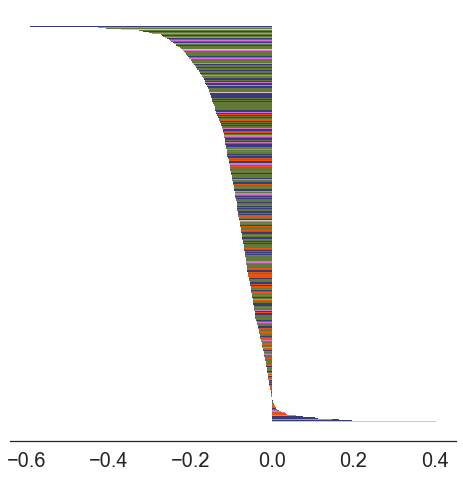

In [307]:
#  viz secRecon gene expression correlation with pseudotime

gene_corr_dpt_viz = gene_corr_dpt[gene_corr_dpt['SCC'].abs() > 0.0].sort_values('SCC',ascending=False)

sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,8))

# Plot horizontal bars
bars = ax.barh(gene_corr_dpt_viz['gene'], gene_corr_dpt_viz['SCC'],height=1.5,linewidth=0,edgecolor='w',color=gene_corr_dpt_viz['color']) #,color=gene_corr_dpt_viz['color'])

# bars = ax.barh(gene_corr_dpt_viz['gene'], gene_corr_dpt_viz['SCC']) #,color=gene_corr_dpt_viz['color'])

# Hide y-axis labels
ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()

In [207]:
# add secRecon annotations per gene
# gene_corr, gene_corr_g
for p in [*gene_corr]:
    p_sys = []
    
    for gene, row in gene_corr[p].iterrows():
        p_sys.append(', '.join(gene_dict.get(gene, {}).get('systems', [])) + ';' + ', '.join(gene_dict.get(gene, {}).get('processes', [])) +';' +  ', '.join(gene_dict.get(gene, {}).get('subprocesses', [])))
#     gene_corr_g[p]['Processes'] = [', '.join(gene_dict.get(gene, {}).get('processes', [])) + ', '.join(gene_dict.get(gene, {}).get('subprocesses', [])) for gene in gene_corr_g[p].index]

    gene_corr[p]['Processes'] = p_sys



# for p in [*gene_corr_g]:
#     p_sys = []
    
#     for gene, row in gene_corr_g[p].iterrows():
#         p_sys.append(', '.join(gene_dict.get(gene, {}).get('systems', [])) + ';' + ', '.join(gene_dict.get(gene, {}).get('processes', [])) +';' +  ', '.join(gene_dict.get(gene, {}).get('subprocesses', [])))
# #     gene_corr_g[p]['Processes'] = [', '.join(gene_dict.get(gene, {}).get('processes', [])) + ', '.join(gene_dict.get(gene, {}).get('subprocesses', [])) for gene in gene_corr_g[p].index]

#     gene_corr_g[p]['Processes'] = p_sys

In [208]:
gene_corr[p]

,SCC,pval,bh_pval,Processes
PIGF,0.065539,0.0,2.341698e-13,Post-translational modifications;Glycerophosph...
TRIM5,0.009216,0.295385,3.192423e-01,Proteostasis;Ubiquitination;
ALG8,0.05888,0.0,4.689581e-11,Post-translational modifications;N-glycan;
B4GALT4,0.057029,0.0,1.859026e-10,"Post-translational modifications;N-glycan, O-g..."
CYTH4,0.067653,0.0,3.847667e-14,Vesicle trafficking;Endocytosis;
...,...,...,...,...
ALG3,0.068564,0.0,1.746617e-14,Post-translational modifications;N-glycan;
GANAB,0.043649,0.000001,1.120297e-06,"Protein conformation, Post-translational modif..."
HSPA12A,0.032179,0.000258,3.573291e-04,Protein conformation;;
DNAJC14,0.045572,0.0,3.678115e-07,Protein conformation;;


In [209]:
# export to csv
for i in [*gene_corr]:
    gene_corr[i].to_csv('../results/correlation/allcells_gene_corr-'+i+'.csv')
for i in [*gene_corr_g]:
    gene_corr_g[i].to_csv('../results/correlation/iggcells_gene_corr-'+i+'.csv')

In [108]:
# gene level correlation performed for each leiden cluster
gene_corr_leiden = {}
for p in cols_response:
    p_corr = pd.DataFrame(index=[i for i in g_data_flt.columns],
                          columns=leiden_c)

    for c in list(set(s_data['leiden'])):
    
        # get cell ids in cluster
        c_cells = s_data[s_data['leiden'] == c].index.tolist()
    
        for i in g_data_flt.columns:
            i_corr = stats.spearmanr(g_data_flt.loc[c_cells,i],s_data.loc[c_cells,p])
            p_corr.loc[i,c+'_SCC']= i_corr[0]
            p_corr.loc[i,c+'_pval']= i_corr[1]
            
    gene_corr_leiden[p] = p_corr

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(war

# Differential Gene Expression across IgG secreting leiden clusters

In [55]:
import gseapy as gp

In [56]:
with open('../data/gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)
    
gobp = gp.read_gmt(path="../data/c5.go.bp.v2023.2.Hs.symbols.gmt")

In [57]:
# import rna obj
rna = sc.read('../data/preprocessed_data/rna_pseudotime_ppiscore.h5')

# https://github.com/scverse/scanpy/issues/2239
rna.uns['log1p']["base"] = None

rna

AnnData object with n_obs × n_vars = 12892 × 36691
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'leiden', 'Ig', 'IgL', 'IgH', 'sec', 'dpt_pseudotime', 'distance', 'time3', 'Proteostasis_score', 'Protein conformation_score', 'Glycerophospholipid (GPI anchor)_score', 'COPII_score', 'Carboxylase_score', 'Keratan sulfate_score', 'ER Ca Homeostasis_score', 'Retrotranslocation_score', 'O-glycan not-mucin_score', 'Mislocalized protein degradation_score', 'Hydroxylysine_score', 'PERK pathway_score', 'O-glycan mucin_score', 'Multimerization_score', 'Acetyltransferase_score', 'Carboxylation_score', 'Apoptosis_score', 'IRE1 pathway_score', 'Phosphorylation_score', 'Dermatan sulfate_score', 'MAPS_score', 'Golgi to PM_score', 'SLC nucleotide-sugar transporter_score', 'Vesicle trafficking_score', 'Kinase_score', 'Endocytosis_score', 'Post-translational modifications_score', 'Lysosomal degradation/Glyco-conjugate degradation_score', 'ER stress

In [124]:
[str(i) for i in igg_clusters]

['0', '1', '2', '4', '10']

In [58]:
# DE test restricting to IgG clusters, with cluster 0 as the reference/base group
# rna_de = sc.tl.rank_genes_groups(rna,groupby='leiden',groups=[str(i) for i in igg_clusters],method='wilcoxon',pts=True)

# set 0 as the reference group
rna_gref = sc.tl.rank_genes_groups(rna,groupby='leiden',
                                   groups=['0','1','2','4','10'],reference='0',
                                   method='wilcoxon',pts=True,copy=True)

# # store all DE results in dict
rna_de_gref = {}
for i in ['1','2','4','10']:
    rna_de_gref[i] = sc.get.rank_genes_groups_df(rna_gref, group=i)
[*rna_de_gref]

['1', '2', '4', '10']

In [59]:
# get all DE results and store as df
rna_de_gref_sig = {}
rna_de_gref_sig_sr = {}
for i in [*rna_de_gref]:
    
    # all DE genes
    rna_de_gref_sig[i] = rna_de_gref[i][rna_de_gref[i]['pvals_adj'] < 0.05]
    rna_de_gref_sig[i]['cluster'] = i+'vs0'
    print(i,'all DE',rna_de_gref_sig[i].shape)
    
    # filter for sr system and get all processes
    i_srg = list(set([*gene_dict]) & set(rna_de_gref_sig[i]['names']))
    rna_de_gref_sig_sr[i] = rna_de_gref_sig[i][rna_de_gref_sig[i]['names'].isin(i_srg)].copy()
    rna_de_gref_sig_sr[i]['system'] = [','.join(gene_dict[g]['systems']) for g in rna_de_gref_sig_sr[i]['names']]
    
    print(i,'sec DE',rna_de_gref_sig_sr[i].shape)
    
rna_de_gref_sig_df = pd.concat(rna_de_gref_sig.values(),ignore_index=True)
rna_de_gref_sig_sr_df = pd.concat(rna_de_gref_sig_sr.values(),ignore_index=True)
rna_de_gref_sig_df

1 all DE (2431, 7)
1 sec DE (290, 8)
2 all DE (4304, 7)
2 sec DE (504, 8)
4 all DE (2122, 7)
4 sec DE (303, 8)
10 all DE (2144, 7)
10 sec DE (303, 8)


/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_12710/747489327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_de_gref_sig[i]['cluster'] = i+'vs0'
/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_12710/747489327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_de_gref_sig[i]['cluster'] = i+'vs0'
/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_12710/747489327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,cluster
0,IGKC,59.666080,7.978428,0.000000e+00,0.000000e+00,1.000000,1vs0
1,RPL39,21.174627,0.663452,1.636684e-99,1.201064e-95,0.999566,1vs0
2,EEF1A1,20.798111,0.644309,4.501851e-96,2.753032e-92,1.000000,1vs0
3,RPL28,20.576534,0.548819,4.454168e-94,2.334747e-90,1.000000,1vs0
4,RPL23,20.136251,0.699122,3.552190e-90,1.629212e-86,0.994360,1vs0
...,...,...,...,...,...,...,...
10996,IGHG4,-17.684587,-3.210981,5.512388e-70,2.889436e-66,0.262048,10vs0
10997,IGHG2,-18.906733,-4.153606,1.003876e-79,6.139039e-76,0.234940,10vs0
10998,IGHG1,-25.418503,-6.361622,1.574824e-142,1.444586e-138,0.659639,10vs0
10999,IGLC3,-29.508043,-8.540436,2.270102e-191,4.164729e-187,0.801205,10vs0


In [98]:
# export DE genes ## Supplementary Table S7
rna_de_gref_sig_df['secRecon_gene'] = [True if i in [*gene_dict] else False for i in rna_de_gref_sig_df['names']]
rna_de_gref_sig_df.to_csv('../results/igg_DE/igg-clusters_DE-genes.csv')

In [74]:
# run GSEA using GO-BP, KEGG, secRecon genesets
rna_de_gref_gsea = {}
for i in [*rna_de_gref_sig]:
    i_gsea = gp.prerank(rnk=rna_de_gref_sig[i].sort_values('logfoldchanges',ascending=False)[['names','logfoldchanges']], # or rnk = rnk,
                         gene_sets=[t2g_dict,'GO_Biological_Process_2023','KEGG_2021_Human'],
                         threads=4,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000, # reduce number to speed up testing
                         outdir=None, # don't write to disk
                         seed=6,
                         verbose=True, # see what's going on behind the scenes
                        )
    
    i_df = i_gsea.res2d.copy()
    i_df['Term'] = i_gsea.res2d['Term'].str.replace('KEGG_2021_Human_','KEGG').str.replace('GO_Cellular_Component_2023_','CC').str.replace('GO_Biological_Process_2023_','BP').str.replace('0_','SR')
    i_df['db'] = [i.split('_')[0] for i in i_df['Term']]
    i_df = i_df[i_df['FDR q-val'] < 0.1]
    
    rna_de_gref_gsea[i] = i_df.reset_index()

2025-02-26 01:17:55,070 [INFO] Parsing data files for GSEA.............................
2025-02-26 01:17:55,078 [INFO] Enrichr library gene sets already downloaded in: /Users/jasminetat/.cache/gseapy, use local file
2025-02-26 01:17:55,201 [INFO] Enrichr library gene sets already downloaded in: /Users/jasminetat/.cache/gseapy, use local file
2025-02-26 01:17:55,264 [INFO] 3868 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-02-26 01:17:55,267 [INFO] 1932 gene_sets used for further statistical testing.....
2025-02-26 01:17:55,267 [INFO] Start to run GSEA...Might take a while..................
2025-02-26 01:18:12,003 [INFO] Congratulations. GSEApy runs successfully................

2025-02-26 01:18:12,063 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-26 01:18:12,064 [INFO] Parsing data files for GSEA.............................
2025-02-26 01:18:12,065 

In [99]:
gsea_all = pd.concat(rna_de_gref_gsea.values(),keys=rna_de_gref_gsea.keys())
gsea_all.reset_index(level=0,inplace=True)
gsea_all['comparison'] = gsea_all['level_0'].astype(str) + 'vs0' 
gsea_all['significant_enrichment'] = [True if i < 0.05 else False for i in gsea_all['FDR q-val']]
gsea_all['Tag %'] = gsea_all['Tag %'].astype(str)
gsea_all

,level_0,index,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,db,comparison,significant_enrichment
0,1,0,prerank,BP_Cytoplasmic Translation (GO:0002181),0.631972,3.248842,0.0,0.0,0.0,70/87,25.79%,RPLP0;RPL31;RACK1;RPL13A;RPL39;RPS28;RPL37;RPS...,BP,1vs0,True
1,1,1,prerank,KEGG_Coronavirus disease,0.612791,3.246579,0.0,0.0,0.0,76/99,25.79%,TNF;RPLP0;RPL23;RPL31;RPL13A;RPL39;RPS28;RPL37...,KEGG,1vs0,True
2,1,2,prerank,BP_Peptide Biosynthetic Process (GO:0043043),0.559965,3.026703,0.0,0.0,0.0,74/108,25.79%,AGO2;RPLP0;RPL31;RPL13A;RPL39;RPS28;RPL37;RPS1...,BP,1vs0,True
3,1,3,prerank,KEGG_Ribosome,0.552351,3.020424,0.0,0.0,0.0,74/109,25.79%,RPLP0;RPL23;RPL31;RPL13A;RPL39;RPS28;RPL37;RPS...,KEGG,1vs0,True
4,1,4,prerank,BP_Macromolecule Biosynthetic Process (GO:0009...,0.532262,2.923881,0.0,0.0,0.0,74/115,24.93%,AGO2;EEF2;RPLP0;RPL31;RPL13A;RPL39;RPS28;RPL37...,BP,1vs0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,10,104,prerank,BP_Positive Regulation Of Protein Kinase B Sig...,-0.564655,-1.84757,0.007001,0.08027,0.974,8/16,17.44%,CCL3;TNF;OSBPL8;TGFB1;HSP90AA1;HSP90AB1;ITGB1;...,BP,10vs0,False
102,10,105,prerank,KEGG_Aldosterone-regulated sodium reabsorption,-0.804582,-1.844643,0.001359,0.081787,0.977,5/5,19.78%,PRKCB;SGK1;IGF1;ATP1B3;KRAS,KEGG,10vs0,False
103,10,106,prerank,BP_Response To Type II Interferon (GO:0034341),-0.561103,-1.842083,0.003417,0.082953,0.979,4/17,2.01%,CCL3;CCL4;IRF8;GBP2,BP,10vs0,False
104,10,107,prerank,BP_Positive Regulation Of Smooth Muscle Cell P...,-0.749515,-1.840369,0.010458,0.083483,0.981,5/6,17.44%,TNF;HDAC1;JUN;TGFB1;IGF1,BP,10vs0,False


In [100]:
# export table ## Supplementary Table S8
gsea_all.to_csv('../results/igg_DE/igg-clusters_DE-gsea-pathways.csv')

In [88]:
# cluster 10 uniquely enriched terms
list(set(gsea_all[gsea_all['level_0'] == '10']['Term']) - set(gsea_all[gsea_all['level_0'] != '10']['Term']))

['BP_Cellular Response To Hypoxia (GO:0071456)',
 'BP_Positive Regulation Of Release Of Sequestered Calcium Ion Into Cytosol (GO:0051281)',
 'KEGG_Dilated cardiomyopathy',
 'BP_Positive Regulation Of Protein Kinase B Signaling (GO:0051897)',
 'KEGG_Aldosterone-regulated sodium reabsorption',
 'KEGG_Arrhythmogenic right ventricular cardiomyopathy',
 'BP_Regulation Of Protein Kinase B Signaling (GO:0051896)',
 'BP_Fat Cell Differentiation (GO:0045444)',
 'BP_Regulation Of Cell Motility (GO:2000145)',
 'BP_Cortical Cytoskeleton Organization (GO:0030865)',
 'BP_Cortical Actin Cytoskeleton Organization (GO:0030866)',
 'BP_B Cell Receptor Signaling Pathway (GO:0050853)',
 'BP_Cellular Response To Organic Cyclic Compound (GO:0071407)',
 'BP_Mitochondrial Electron Transport, Cytochrome C To Oxygen (GO:0006123)',
 'BP_Cellular Response To Decreased Oxygen Levels (GO:0036294)',
 'BP_Cellular Response To Hormone Stimulus (GO:0032870)',
 'BP_Negative Regulation Of Apoptotic Signaling Pathway (GO:2

In [179]:
# print the min and max LFC values for each cluster relative to cluster 0
for i in [*rna_de_gref_sig_sr]:
    print(i,
          rna_de_gref_sig_sr[i].logfoldchanges.max(),
         rna_de_gref_sig_sr[i].logfoldchanges.min())
# rna_de_gref_sig_sr_df.logfoldchanges.max(),rna_de_gref_sig_sr_df.logfoldchanges.min()

1 0.7524611949920654 -0.257138192653656
2 0.1692749410867691 -2.1224617958068848
4 -0.11611293256282806 -1.2829464673995972
10 -0.2095140963792801 -2.4448399543762207


In [94]:
# obtain the cluster 10 vs 0 unique genes
## IFITM3 - viral response (MX1 also DE, not unique for cluster 10)
## CLEC2B - immune response, cell signaling/adhesion
## COMMD10 MHC1 class processing

c10_deg = rna_de_gref_sig['10']['names'].values.tolist()
c10_deg

c10_deg_uniq = list(set(c10_deg) - set(rna_de_gref_sig_df[rna_de_gref_sig_df['cluster'] != '10vs0']['names']))

len(c10_deg), len(c10_deg_uniq), c10_deg_uniq

(2144,
 9,
 ['HOXB2',
  'IFITM3',
  'MIR29B2CHG',
  'TEX9',
  'COMMD10',
  'CLEC2B',
  'ESCO1',
  'PARP14',
  'MANEA-DT'])